# Imports

In [1]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
from time import time
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import json
import os
import datetime
from scipy import interpolate
from time import sleep

# lenet tensorflow class build to be called from extern classes

In [2]:
class LeNetTensor:
    def __init__(self, mnistdata):
        self.mnist =  mnistdata 
        # input_data.read_data_sets('MNIST_data', one_hot=True)
        
    def plottrainlifesetup(self, n_epoch, title):
        
        if float(mpl.__version__[:3]) >= 1.5:
            %matplotlib notebook
        else:
            %matplotlib inline

        self.fig, self.ax = plt.subplots(1, 1)
        self.ax.set_title(title)
        self.ax.set_xlim([0, n_epoch])
        self.ax.set_ylim([0, 1])
        self.ax.set_xlabel('Epoch')
        self.ax.set_ylabel('Validation Accurancy')

    def plottrainlifeupdate(self, dataC, csize, labels):  
        # stolen from ml lecture
        if self.ax.lines:
            for i, data in enumerate(dataC):
                self.ax.lines[i].set_ydata(data)
            self.ax.set_ylim([0,  1])
            self.fig.canvas.draw()
        else:
            for i in range(0,csize):
                if i <= len(dataC) -1:
                    self.ax.plot(dataC[i], label=labels[i])
                else:
                    a = np.empty((len(dataC),1))
                    a[:] = np.nan
                    self.ax.plot(a, label=labels[i])
            self.ax.legend(loc='upper right')
        self.fig.canvas.draw()

        
        

    def validation_accuracy(self, loaded_mnist, accuracy, x, y_, batch_size=64):
        """ A function that calculates the accuracy on the validation data."""
        batch_num = int(loaded_mnist.test.num_examples / batch_size)
        test_accuracy = 0
        
        for i in range(batch_num):
            batch = loaded_mnist.test.next_batch(batch_size)
            test_accuracy += accuracy.eval(feed_dict={x: batch[0],
                                                      y_: batch[1]})

        test_accuracy /= batch_num
        return test_accuracy


    def convNN(self, x, dev, num_filters, biasvalue, filtersize):
        """
        actual implementation of cnn as mentionend in task 
        """

        # reshape image for input layer
        with tf.device(dev), tf.name_scope('input'):
            input_layer = tf.reshape(x, [-1, 28, 28, 1])

        # convolutional 1
        with tf.device(dev), tf.name_scope('conv1'):
            conv1 = tf.layers.conv2d(inputs=input_layer, filters=num_filters, kernel_size=[filtersize, filtersize], padding="SAME", activation=tf.nn.relu)

        # max pool layer 1
        with tf.device(dev), tf.name_scope('pool1'):           
            pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=1, padding='SAME')

        # convolutional 2
        with tf.device(dev), tf.name_scope('conv2'):
             conv2 = tf.layers.conv2d(inputs=pool1, filters=num_filters, kernel_size=[filtersize, filtersize], padding="SAME", activation=tf.nn.relu)
        
        # max pool layer 2
        with tf.device(dev), tf.name_scope('pool2'):
             pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=1, padding='SAME')

        # flatten input and FC layer 1 
        with tf.device(dev), tf.name_scope('dense1'):
            # fully connected layer
            pool2_flat = tf.reshape(pool2, [-1, 28*28*num_filters])
            dense1 = tf.layers.dense(inputs=pool2_flat, units=128, activation=tf.nn.relu)

        # readout layer, fully connected
        with tf.device(dev), tf.name_scope('output'):
             logits = tf.layers.dense(inputs=dense1, units=10)

        # output probs
        return logits

    def fill_nan(self, A):
        '''
        interpolate to fill nan values
        stolen from https://stackoverflow.com/questions/6518811/interpolate-nan-values-in-a-numpy-array
        '''
        inds = np.arange(A.shape[0])
        good = np.where(np.isfinite(A))
        f = interpolate.interp1d(inds[good], A[good],bounds_error=False)
        B = np.where(np.isfinite(A),A,f(inds))
        return B
    
    
    def testArchitecture(self, learning_rate=0.1, num_filters=16, device='cpu', biasvalue=0.1, numepoch=2000, filtersize=2, batchsize=50, calcstep=100):
        """ 
        Builds a conv NN with the given parameters and trains it, 
        calculating the number of trainable parameters and measuring 
        the runtime as well as the performance during training.
        """
        
        dev = '/GPU:0' if device == 'gpu' else '/cpu:0'
        print('Train of convolutional NN with {} filters, learning rate {}, using the {}.'.format(num_filters, learning_rate, device))
        
        with tf.device(dev), tf.name_scope('alloc'):
            # DATA ALLOC
            x = tf.placeholder(tf.float32, [None, 784])
            y_ = tf.placeholder(tf.float32, [None, 10])
        
        print("* Set up NN * ")
        y = self.convNN(x, dev, num_filters, biasvalue, filtersize)
        print("* Setup succesful *")
        
        with tf.device(dev), tf.name_scope('loss'):
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y)
            cross_entropy = tf.reduce_mean(cross_entropy)
        tf.summary.scalar('cross_entropy', cross_entropy)
        
        acc = []

        with tf.device(dev), tf.name_scope("SGD"):
            train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
            
        with tf.device(dev), tf.name_scope('accuracy'):
            correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
            correct_prediction = tf.cast(correct_prediction, tf.float32)
            accuracy = tf.reduce_mean(correct_prediction)
            
        tf.summary.scalar('accuracy', accuracy)
        merged_summary_op = tf.summary.merge_all()
        
        with tf.device(dev), tf.Session(config=tf.ConfigProto(log_device_placement=False)) as sess:
            sess.run(tf.global_variables_initializer())
            start_time = time()
            for epoch in range(numepoch+1):
                batch = self.mnist.train.next_batch(batchsize)
                batch_val = self.mnist.validation.next_batch(batchsize)
                
                if epoch % calcstep == 0:
                    val_accuracy = self.validation_accuracy(self.mnist, accuracy, x, y_)
                    loss = 1 - val_accuracy
                    acc.append(val_accuracy)
                    print('epoch {}, validation accuracy {:.2f}%'.format(epoch, val_accuracy*100), end='\n')
                else:
                    acc.append(None)
                with tf.device(dev):
                    train_step.run(feed_dict={x: batch[0], y_: batch[1]})
            
            # save
            results = dict()
            results["lr"] = learning_rate
            results["num_filters"] = num_filters
            results["batch_size"] = batchsize
            results["learning_curve"] = acc
            results["test_error"] = 1-val_accuracy

            path = "./output/"
            runid = str(datetime.datetime.now())
            
            
            os.makedirs(path, exist_ok=True )
                
                
                
            fname = os.path.join(path, "results_run_%s.json" % runid)

            fh = open(fname, "w")
            json.dump(results, fh)
            fh.close()
            return acc, loss


# Init run 

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


<IPython.core.display.Javascript object>


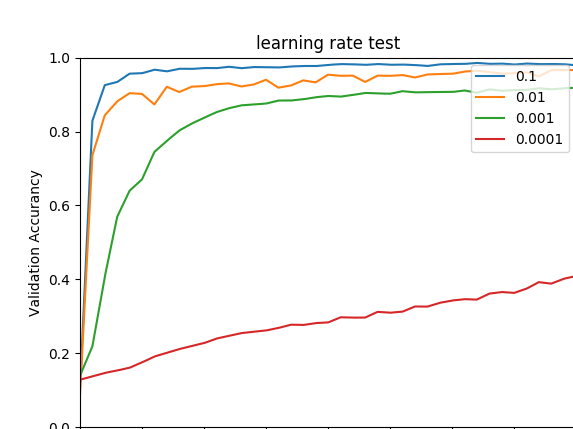

Train of convolutional NN with 16 filters, learning rate 0.1, using the cpu.
* Set up NN * 
* Setup succesful *
epoch 0, validation accuracy 10.27%
epoch 50, validation accuracy 82.92%
epoch 100, validation accuracy 92.55%
epoch 150, validation accuracy 93.39%
epoch 200, validation accuracy 95.65%
epoch 250, validation accuracy 95.77%
epoch 300, validation accuracy 96.73%
epoch 350, validation accuracy 96.27%
epoch 400, validation accuracy 96.99%
epoch 450, validation accuracy 96.94%
epoch 500, validation accuracy 97.19%
epoch 550, validation accuracy 97.14%
epoch 600, validation accuracy 97.53%
epoch 650, validation accuracy 97.13%
epoch 700, validation accuracy 97.45%
epoch 750, validation accuracy 97.39%
epoch 800, validation accuracy 97.32%
epoch 850, validation accuracy 97.60%
epoch 900, validation accuracy 97.74%
epoch 950, validation accuracy 97.71%
epoch 1000, validation accuracy 98.02%
epoch 1050, validation accuracy 98.25%
epoch 1100, validation accuracy 98.20%
epoch 1150, va

<IPython.core.display.Javascript object>

Train of convolutional NN with 16 filters, learning rate 0.1, using the cpu.
* Set up NN * 
* Setup succesful *
epoch 0, validation accuracy 10.57%
epoch 50, validation accuracy 73.43%
epoch 100, validation accuracy 85.16%
epoch 150, validation accuracy 87.07%
epoch 200, validation accuracy 90.26%
epoch 250, validation accuracy 86.10%
epoch 300, validation accuracy 91.88%
epoch 350, validation accuracy 90.37%
epoch 400, validation accuracy 92.47%
epoch 450, validation accuracy 92.79%
epoch 500, validation accuracy 92.33%
epoch 550, validation accuracy 93.39%
epoch 600, validation accuracy 91.81%
epoch 650, validation accuracy 94.25%
epoch 700, validation accuracy 93.93%
epoch 750, validation accuracy 93.64%
epoch 800, validation accuracy 94.30%
epoch 850, validation accuracy 94.64%
epoch 900, validation accuracy 94.84%
epoch 950, validation accuracy 94.40%
epoch 1000, validation accuracy 95.02%
epoch 1050, validation accuracy 93.47%
epoch 1100, validation accuracy 94.76%
epoch 1150, va

In [ ]:
ln = LeNetTensor(input_data.read_data_sets('MNIST_data', one_hot=True))
numepoch = 2000
calcstep = 50
dataC  = []
ln.plottrainlifesetup(numepoch, "learning rate test")
for testing_learning_rate in [0.1, 0.01, 0.001, 0.0001]:
    data, loss = ln.testArchitecture(learning_rate=testing_learning_rate, num_filters=16, device='cpu', numepoch=numepoch, filtersize=3, batchsize=50, calcstep=calcstep)
    data = ln.fill_nan(np.array(data, dtype=float))
    dataC.append(data)
    tf.reset_default_graph()
ln.plottrainlifeupdate(np.array(dataC, dtype=float), 4, ["0.1", "0.01", "0.001", "0.0001"])

time()
sleep(1)


dataC  = []
ln.plottrainlifesetup(numepoch, "filtersize test")
for size_of_filters in [1, 3, 5, 7]:
    data, loss = ln.testArchitecture(learning_rate=0.1, num_filters=16, device='cpu', numepoch=numepoch, filtersize=size_of_filters, batchsize=50, calcstep=calcstep)
    data = ln.fill_nan(np.array(data, dtype=float))
    dataC.append(data)
    tf.reset_default_graph()
ln.plottrainlifeupdate(np.array(dataC, dtype=float), 4, ["1", "3", "5", "7"])


